In [ ]:
import pickle
import torch
from utils import dataset_mp, prd2XY, test
from agg import MLPRegressor
import numpy as np

In [2]:
portion = 0.5
dataset_name = 'linux'
dataset = dataset_mp[dataset_name]
trans = 'hv2'
n_samples = 50

preds = pickle.load(open('data/val/val_%s_%s_%d_%.2ftrain_preds.pkl' % (dataset, trans, n_samples, portion), 'rb'))
preds = np.reshape(preds, (-1, n_samples + 1))
gts = pickle.load(open('data/val/val_%s_%.2ftrain_gts.pkl' % (dataset, portion), 'rb'))

preds.shape, gts.shape

((300000, 51), (300000,))

In [3]:
Xs_val, Ys_val, mi_val, ma_val, oYs_val = prd2XY(preds, gts, n_samples=n_samples)
Xs_val.shape, Ys_val.shape, mi_val.shape, ma_val.shape, oYs_val.shape

((300000, 402), (300000,), (300000,), (300000,), (300000,))

100%|██████████| 500/500 [00:43<00:00, 11.55it/s, train_mse=0.00602]


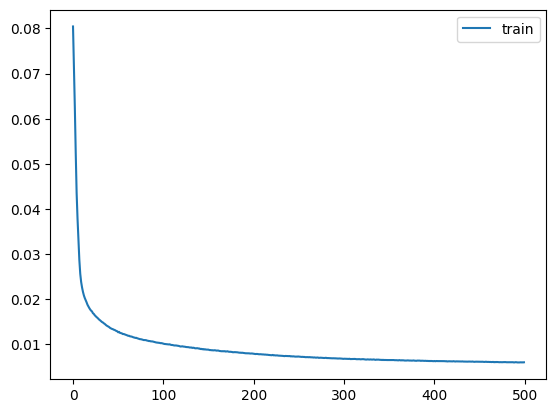

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

model = MLPRegressor(
    hidden_sizes=[200, 100, 50], 
    p=0.5,
)
model.fit(Xs_val, Ys_val, batch_size=16000, n_epochs=500, lr=0.0001, weight_decay=0.0)
torch.save(model.mlp.state_dict(), 'agg_model/%s.pt' % dataset)

In [5]:
preds_test = pickle.load(open('data/test/test_%s_%s_%d_preds.pkl' % (dataset, trans, n_samples), 'rb'))
preds_test = np.reshape(preds_test, (-1, n_samples + 1))
gts_test = pickle.load(open('data/test/test_%s_gts.pkl' % (dataset, ), 'rb'))

inner_set_test, _ = torch.load(f'expts/data/{dataset}/inner_test.pt', map_location='cpu')
_, _, lb_test, ub_test = inner_set_test
preds_test.shape, gts_test.shape, lb_test.size(), ub_test.size() 

((160000, 51), (160000,), torch.Size([160000]), torch.Size([160000]))

In [6]:
Xs_test, Ys_test, mi_test, ma_test, oYs_test = prd2XY(preds_test, gts_test, n_samples=n_samples)
Xs_test.shape, Ys_test.shape, mi_test.shape, ma_test.shape, oYs_test.shape

((160000, 402), (160000,), (160000,), (160000,), (160000,))

In [7]:
test_err_orig, test_err = test(model, Xs_test, lb_test, ub_test, mi_test, ma_test, oYs_test)
print(test_err_orig, test_err)

0.41511092 0.24058245
